# Energy Consumption Time Series Forecasting

**Organization:** DevelopersHub Corporation  
**Intern:** Ashna Imtiaz

---

## Task 3: Energy Consumption Time Series Forecasting  

### Objective  
Forecast short-term household energy usage using historical time-based patterns.

### Dataset  
**Household Power Consumption Dataset**  

### 📝 Instructions  
- Parse and resample the time series data  
- Engineer time-based features (e.g., hour of day, weekday/weekend)  
- Compare performance of **ARIMA**, **Prophet**, and **XGBoost** models  
- Plot actual vs. forecasted energy usage for visualization  

---


In [23]:
!pip install statsmodels prophet xgboost -q

In [57]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import os 
import math

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

In [25]:
# User Editable paths & params
DATA_PATH = "/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt"
RESAMPLE_RULE = "H"      # 'H' for hourly, 'D' for daily
TARGET_COL = "Global_active_power"  # dataset's target column name
TEST_SIZE = 0.2          # proportion of data reserved for test (most recent)
LAGS = [1, 24, 48, 72]   # example lags (hours); tune for your frequency
ROLL_WINDOWS = [3, 24]   # rolling mean windows (in hours)
RANDOM_SEED = 42

## 1) LOAD AND PARSE DATA

In [26]:
def load_and_parse(path):
    df = pd.read_csv(
        path,
        sep=';',
        low_memory=False,
        na_values=['?', 'NA', ''],
        parse_dates={'datetime': ['Date', 'Time']},
        infer_datetime_format=True
    )
    # Convert to numeric
    for col in df.columns:
        if col != 'datetime':
            df[col]=pd.to_numeric(df[col], errors='coerce')
    df = df.set_index('datetime').sort_index()
    return df

In [27]:
df_raw = load_and_parse(DATA_PATH)
print("Raw data shape:", df_raw.shape)
df_raw.head()

Raw data shape: (2075259, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [67]:
df_raw

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


# 2) RESAMPLE

In [28]:
# We'll resample by the RESAMPLE_RULE, aggregating by mean for numeric columns.
df_resampled = df_raw.resample(RESAMPLE_RULE).mean()

In [29]:
# Drop rows where target is NaN (after resampling)
df_resampled = df_resampled[[TARGET_COL]].copy()
df_resampled = df_resampled.dropna(subset=[TARGET_COL])

In [30]:
print("\nResampled data shape (after dropping NA target):", df_resampled.shape)
df_resampled.head()


Resampled data shape (after dropping NA target): (34168, 1)


,Global_active_power
datetime,
2006-12-16 17:00:00,4.222889
2006-12-16 18:00:00,3.632200
2006-12-16 19:00:00,3.400233
2006-12-16 20:00:00,3.268567
2006-12-16 21:00:00,3.056467


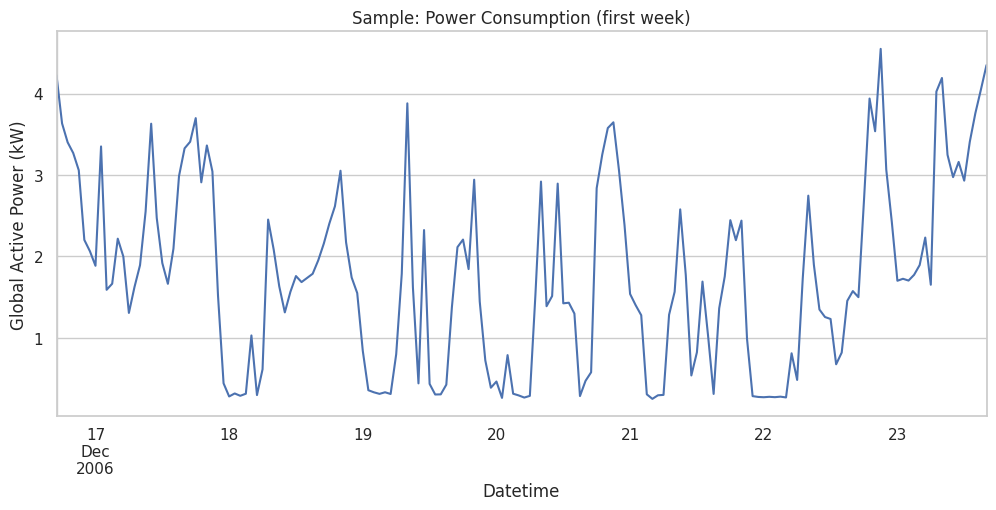

In [31]:
# Optional quick visualization of a slice (first 7 days)
df_resampled[TARGET_COL].iloc[:24*7].plot(title="Sample: Power Consumption (first week)")
plt.xlabel("Datetime")
plt.ylabel("Global Active Power (kW)")
plt.show()

# 3) TIME-BASED FEATURE ENGINEERING

In [32]:
def make_time_features(df, time_index_name='datetime'):
    # df index must be datetime
    df_feat = df.copy()
    idx = df_feat.index
    df_feat['hour'] = idx.hour
    df_feat['day'] = idx.day
    df_feat['month'] = idx.month
    df_feat['dayofweek'] = idx.dayofweek
    df_feat['is_weekend'] = (idx.dayofweek >= 5).astype(int)
    # cyclic encoding for hour and month (helpful for tree and numeric models)
    df_feat['hour_sin'] = np.sin(2 * np.pi * df_feat['hour'] / 24)
    df_feat['hour_cos'] = np.cos(2 * np.pi * df_feat['hour'] / 24)
    df_feat['month_sin'] = np.sin(2 * np.pi * (df_feat['month']-1) / 12)
    df_feat['month_cos'] = np.cos(2 * np.pi * (df_feat['month']-1) / 12)
    return df_feat

In [33]:
df_feat = make_time_features(df_resampled)
df_feat.head()

,Global_active_power,hour,day,month,dayofweek,is_weekend,hour_sin,hour_cos,month_sin,month_cos
datetime,,,,,,,,,,
2006-12-16 17:00:00,4.222889,17,16,12,5,1,-0.965926,-2.588190e-01,-0.5,0.866025
2006-12-16 18:00:00,3.632200,18,16,12,5,1,-1.000000,-1.836970e-16,-0.5,0.866025
2006-12-16 19:00:00,3.400233,19,16,12,5,1,-0.965926,2.588190e-01,-0.5,0.866025
2006-12-16 20:00:00,3.268567,20,16,12,5,1,-0.866025,5.000000e-01,-0.5,0.866025
2006-12-16 21:00:00,3.056467,21,16,12,5,1,-0.707107,7.071068e-01,-0.5,0.866025


In [34]:
# Add lag features & rolling means
for lag in LAGS:
    df_feat[f"lag_{lag}"] = df_feat[TARGET_COL].shift(lag)

for w in ROLL_WINDOWS:
    df_feat[f"rollmean_{w}"] = df_feat[TARGET_COL].shift(1).rolling(window=w, min_periods=1).mean()

In [35]:
# Drop NA rows created by shifting
df_feat = df_feat.dropna()
print("\nFeatures shape after adding lags/rolling:", df_feat.shape)
print(df_feat.columns)



Features shape after adding lags/rolling: (34096, 16)
Index(['Global_active_power', 'hour', 'day', 'month', 'dayofweek',
       'is_weekend', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'lag_1',
       'lag_24', 'lag_48', 'lag_72', 'rollmean_3', 'rollmean_24'],
      dtype='object')


# 4) TRAIN / TEST SPLIT (time-series aware)

In [36]:
n = len(df_feat)
n_test = int(math.ceil(TEST_SIZE * n))
n_train = n - n_test
train = df_feat.iloc[:n_train].copy()
test = df_feat.iloc[n_train:].copy()

In [37]:
print(f"\nTrain shape: {train.shape}, Test shape: {test.shape}")


Train shape: (27276, 16), Test shape: (6820, 16)


In [73]:
train.head(3)

,Global_active_power,hour,day,month,dayofweek,is_weekend,hour_sin,hour_cos,month_sin,month_cos,lag_1,lag_24,lag_48,lag_72,rollmean_3,rollmean_24
datetime,,,,,,,,,,,,,,,,
2006-12-19 17:00:00,2.1115,17,19,12,1,0,-0.965926,-2.588190e-01,-0.5,0.866025,1.372133,2.154900,3.406767,4.222889,0.698544,1.325117
2006-12-19 18:00:00,2.2047,18,19,12,1,0,-1.000000,-1.836970e-16,-0.5,0.866025,2.111500,2.402533,3.697100,3.632200,1.301667,1.323308
2006-12-19 19:00:00,1.8421,19,19,12,1,0,-0.965926,2.588190e-01,-0.5,0.866025,2.204700,2.614500,2.908400,3.400233,1.896111,1.315065


In [39]:
# Metrics helper
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def print_metrics(y_true, y_pred, label="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape_v = mape(y_true, y_pred)
    print(f"{label} -- MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape_v:.2f}%")

# MODEL 1: ARIMA
#### ->Good for baseline forecasting.

After applying `ARIMA`, we will obtain a good baseline for forecasting. However, ARIMA only models the autoregressive and moving average components, assuming the data is stationary.

In [58]:
# Fit ARIMA model (p, d, q) parameters chosen manually or via grid search/ACF-PACF
model = ARIMA(train['Global_active_power'], order=(5,1,0))
arima_fit = model.fit()


In [59]:
# Forecast
forecast = arima_fit.forecast(steps=len(test))

In [60]:
# Evaluation metrics
mae = mean_absolute_error(test['Global_active_power'], forecast)
rmse = np.sqrt(mean_squared_error(test['Global_active_power'], forecast))
mape = np.mean(np.abs((test['Global_active_power'] - forecast) / test['Global_active_power'])) * 100

print(f"ARIMA -- MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

ARIMA -- MAE: 0.5995, RMSE: 0.7565, MAPE: nan%


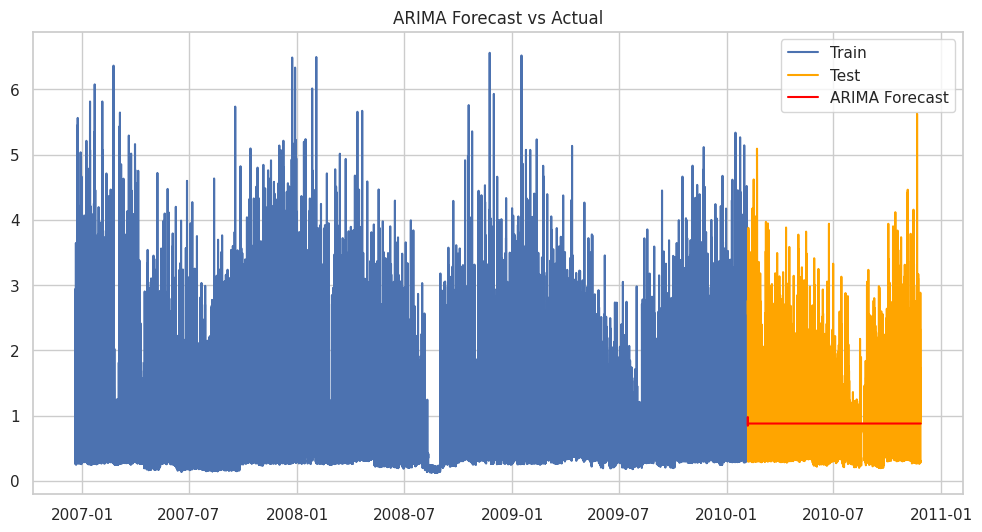

In [61]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(train['Global_active_power'], label="Train")
plt.plot(test['Global_active_power'], label="Test", color="orange")
plt.plot(test.index, forecast, label="ARIMA Forecast", color="red")
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()

# SARIMAX (Univariate classical model)

***SARIMAX (Seasonal ARIMA with Exogenous variables)*** is a more generalized model that extends ARIMA by:

* Capturing **seasonality** (weekly, monthly, yearly trends).

* Allowing the use of **exogenous features** (external variables that might affect the target).

In [40]:
# chosse a moderate configuration: order=(1,1,1), seasonal_order=(1,1,1,24) for hourly daily seasonality
print("\nFitting SARIMAX...")
sarima_order = (1,1,1)
seasonal_order = (1,1,1,24)  # 24 for daily seasonality in hourly data
model_sarimax = SARIMAX(train[TARGET_COL], order=sarima_order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
res_sarimax = model_sarimax.fit(disp=False)
print(res_sarimax.summary())


Fitting SARIMAX...
                                     SARIMAX Results                                      
Dep. Variable:                Global_active_power   No. Observations:                27276
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -24047.515
Date:                            Tue, 26 Aug 2025   AIC                          48105.029
Time:                                    17:42:03   BIC                          48146.089
Sample:                                         0   HQIC                         48118.265
                                          - 27276                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6196      0.004    172.042      0.000       0.613       0.627
ma.L1         -

Since many real-world time series (like sales, traffic, or stock data) often show repeating seasonal patterns, SARIMAX helps us model those effects better compared to plain ARIMA.

### - ARIMA = Good baseline model
###  - SARIMAX = More advanced, handles seasonality + external factors

In [41]:
# Forecast for the test period
start = len(train)
end = len(train) + len(test) - 1
pred_sarimax = res_sarimax.predict(start=start, end=end, dynamic=False)

# Align with test index
pred_sarimax.index = test.index  

print_metrics(test[TARGET_COL], pred_sarimax, label="SARIMAX")


SARIMAX -- MAE: 1.3451, RMSE: 1.5594, MAPE: 276.50%


# MODEL 2: Prophet

In [42]:
print("\nFitting Prophet...")
# Prophet wants ds,y columns
df_prophet = train[[TARGET_COL]].reset_index().rename(columns={'datetime':'ds', TARGET_COL: 'y'}) if 'datetime' in train.index.names else train.reset_index().rename(columns={train.index.name or 'index':'ds', TARGET_COL:'y'})
# But sometimes index.name is None; we ensure correct columns
df_prophet = train.reset_index()[['datetime', TARGET_COL]].rename(columns={'datetime':'ds', TARGET_COL:'y'})
m = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=True)
m.fit(df_prophet)


Fitting Prophet...


17:42:05 - cmdstanpy - INFO - Chain [1] start processing
17:42:09 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
# Create future dataframe (train + test period)
future = m.make_future_dataframe(periods=len(test), freq=RESAMPLE_RULE)
forecast_prophet = m.predict(future)

# Align forecast with test period safely
forecast_prophet = forecast_prophet.set_index('ds')['yhat']
forecast_prophet = forecast_prophet.reindex(test.index)  # avoids KeyError

# Optional: handle missing timestamps
forecast_prophet = forecast_prophet.fillna(method='ffill')

# Evaluate
print_metrics(test[TARGET_COL], forecast_prophet, label="Prophet")


Prophet -- MAE: 0.5763, RMSE: 0.7176, MAPE: 86.80%


# MODEL 3: XGBoost

In [48]:
# print("\nTraining XGBoost (with engineered features)")
FEATURES = [c for c in train.columns if c != TARGET_COL]


In [49]:
X_train = train[FEATURES].values
y_train = train[TARGET_COL].values
X_test = test[FEATURES].values
y_test = test[TARGET_COL].values


In [50]:

# scale features (important for regularized models, though XGBoost is tree-based and not strictly required)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [51]:
xgb_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=RANDOM_SEED, objective='reg:squarederror')
xgb_model.fit(X_train_scaled, y_train, eval_set=[(X_train_scaled, y_train)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [52]:

pred_xgb = xgb_model.predict(X_test_scaled)
print_metrics(y_test, pred_xgb, label="XGBoost")

XGBoost -- MAE: 0.3279, RMSE: 0.4749, MAPE: 41.86%


Lets Compare:

* Prophet: MAE = 0.5763, RMSE = 0.7176, MAPE = 86.80%

* XGBoost: MAE = 0.3279, RMSE = 0.4749, MAPE = 41.86%

## Observations:

* Lower MAE & RMSE → XGBoost is predicting closer to the actual values.

* MAPE dropped from ~87% to ~42% → Huge improvement in percentage error.

* This suggests that XGBoost handles the non-linear patterns in household energy usage much better than Prophet (which assumes smoother seasonal trends).

## PLOT: Actual vs Forecasted (test period)

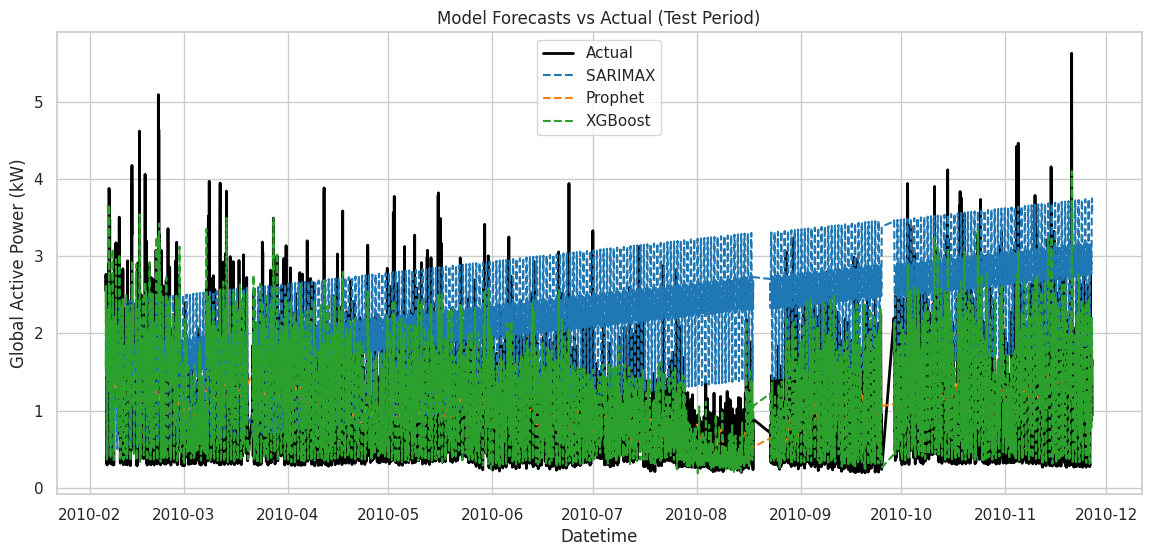

In [53]:
def plot_forecasts(test_index, actual, preds_dict, title="Actual vs Forecast"):
    plt.figure(figsize=(14,6))
    plt.plot(test_index, actual, label="Actual", linewidth=2, color='black')
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    for i, (name, pred) in enumerate(preds_dict.items()):
        plt.plot(test_index, pred, label=name, linestyle='--', linewidth=1.5, color=colors[i % len(colors)])
    plt.xlabel("Datetime")
    plt.ylabel("Global Active Power (kW)")
    plt.title(title)
    plt.legend()
    plt.show()
    
preds = {
    "SARIMAX": pred_sarimax,
    "Prophet": forecast_prophet,
    "XGBoost": pd.Series(pred_xgb, index=test.index)
}

plot_forecasts(test.index, test[TARGET_COL], preds, title="Model Forecasts vs Actual (Test Period)")


# Visualize residuals

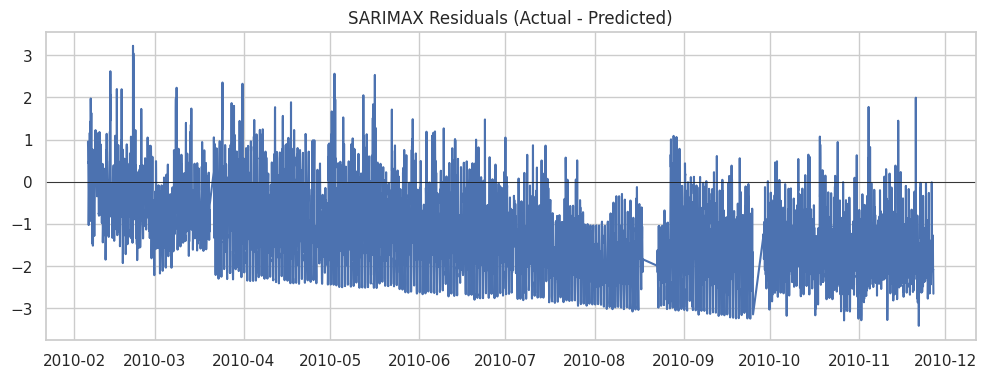

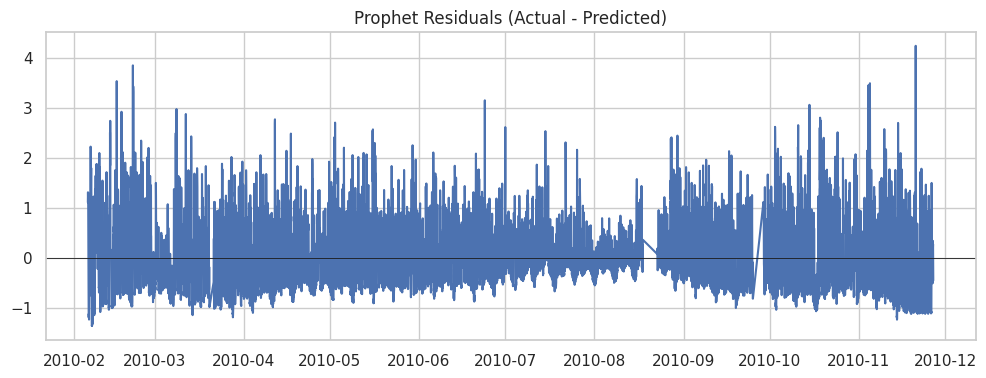

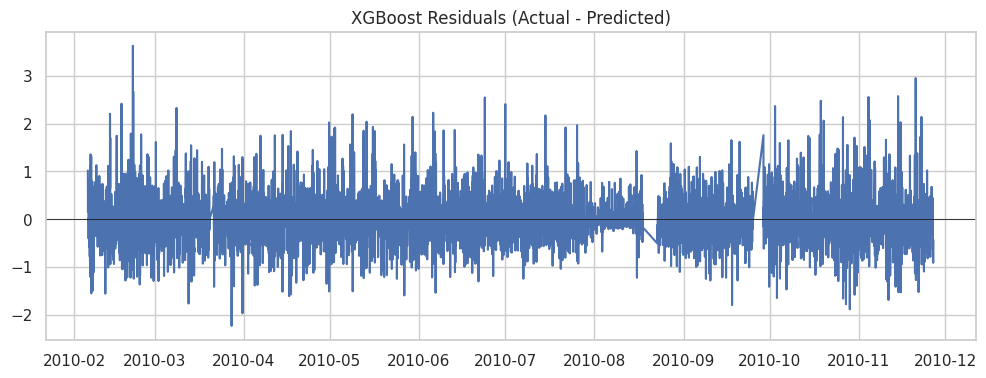

In [54]:
def plot_residuals(y_true, y_pred, label="Model"):
    resid = y_true - y_pred
    plt.figure(figsize=(12,4))
    plt.plot(resid.index, resid, label=f"{label} Residuals")
    plt.axhline(0, color='k', linewidth=0.6)
    plt.title(f"{label} Residuals (Actual - Predicted)")
    plt.show()

plot_residuals(test[TARGET_COL], pred_sarimax, label="SARIMAX")
plot_residuals(test[TARGET_COL], forecast_prophet, label="Prophet")
plot_residuals(test[TARGET_COL], pd.Series(pred_xgb, index=test.index), label="XGBoost")


# SUMMARY TABLE of Metrics

In [55]:

results_summary = []
for name, pred in preds.items():
    y_true = test[TARGET_COL].values
    y_pred = np.array(pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape_v = mape(y_true, y_pred)
    results_summary.append({"model": name, "MAE": mae, "RMSE": rmse, "MAPE": mape_v})

results_df = pd.DataFrame(results_summary).set_index('model')
print("\nPerformance summary on test set:")
print(results_df)



Performance summary on test set:
              MAE      RMSE        MAPE
model                                  
SARIMAX  1.345114  1.559370  276.499807
Prophet  0.576337  0.717556   86.796867
XGBoost  0.327918  0.474914   41.863331


In [ ]:

# Save summary to CSV
results_df.to_csv("model_performance_summary.csv")
print("\nSaved performance summary to model_performance_summary.csv")
results_df.head()
